# 社区划分

In [1]:
#导入数据集
from dgl.data import CoraGraphDataset
dataset = CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [2]:
g = dataset[0]#Cora数据集只有一个图

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
nx_g = g.to_networkx().to_undirected() #转换为networkx格式
pos = nx.kamada_kawai_layout(nx_g) #确定绘图时节点的位置

In [4]:
#color列表，用于绘图
color_xkcd = ['xkcd:red', 'xkcd:blue', 'xkcd:green', 'xkcd:purple', 'xkcd:pink', 'xkcd:brown', 'xkcd:yellow', 'xkcd:light blue', 'xkcd:teal', 'xkcd:orange', 'xkcd:light green', 'xkcd:magenta', 'xkcd:violet', 'xkcd:sky blue', 'xkcd:lime green', 'xkcd:light purple', 'xkcd:dark green', 'xkcd:turquoise', 'xkcd:lavender', 'xkcd:tan', 'xkcd:cyan', 'xkcd:dark blue', 'xkcd:aqua', 'xkcd:olive', 'xkcd:peach', 'xkcd:lilac', 'xkcd:salmon', 'xkcd:beige', 'xkcd:bright green', 'xkcd:royal blue']

## 基于群组的社区划分

### 层次化社区划分：Girvan-Newman算法

In [29]:
from networkx.algorithms import community
import itertools
comp = community.girvan_newman(nx_g) #调用GN算法，返回迭代器
limited = itertools.takewhile(lambda c: len(c) >= 7, comp) #返回所有社区数量大于7的分类

In [ ]:
b = []
for communities in limited:
    b.append(tuple(c for c in communities if 5 <= len(c) <= 1000))
#对于每种分类，只保留社区人数在5到1000之间的社区，共有518种划分

In [199]:
b1 = []
for coms in b:
    b1.append([list(com) for com in coms if len(com) >= 15])
#只保留节点大于15的社区

In [13]:
#寻找对应社区数量的分类
for i in range(581):
    if len(b1[i]) == 15:
        print(i)
        break

402


In [14]:
commu_gn = sorted(b1[402], key = lambda x:len(x), reverse = True) #挑选出社区划分

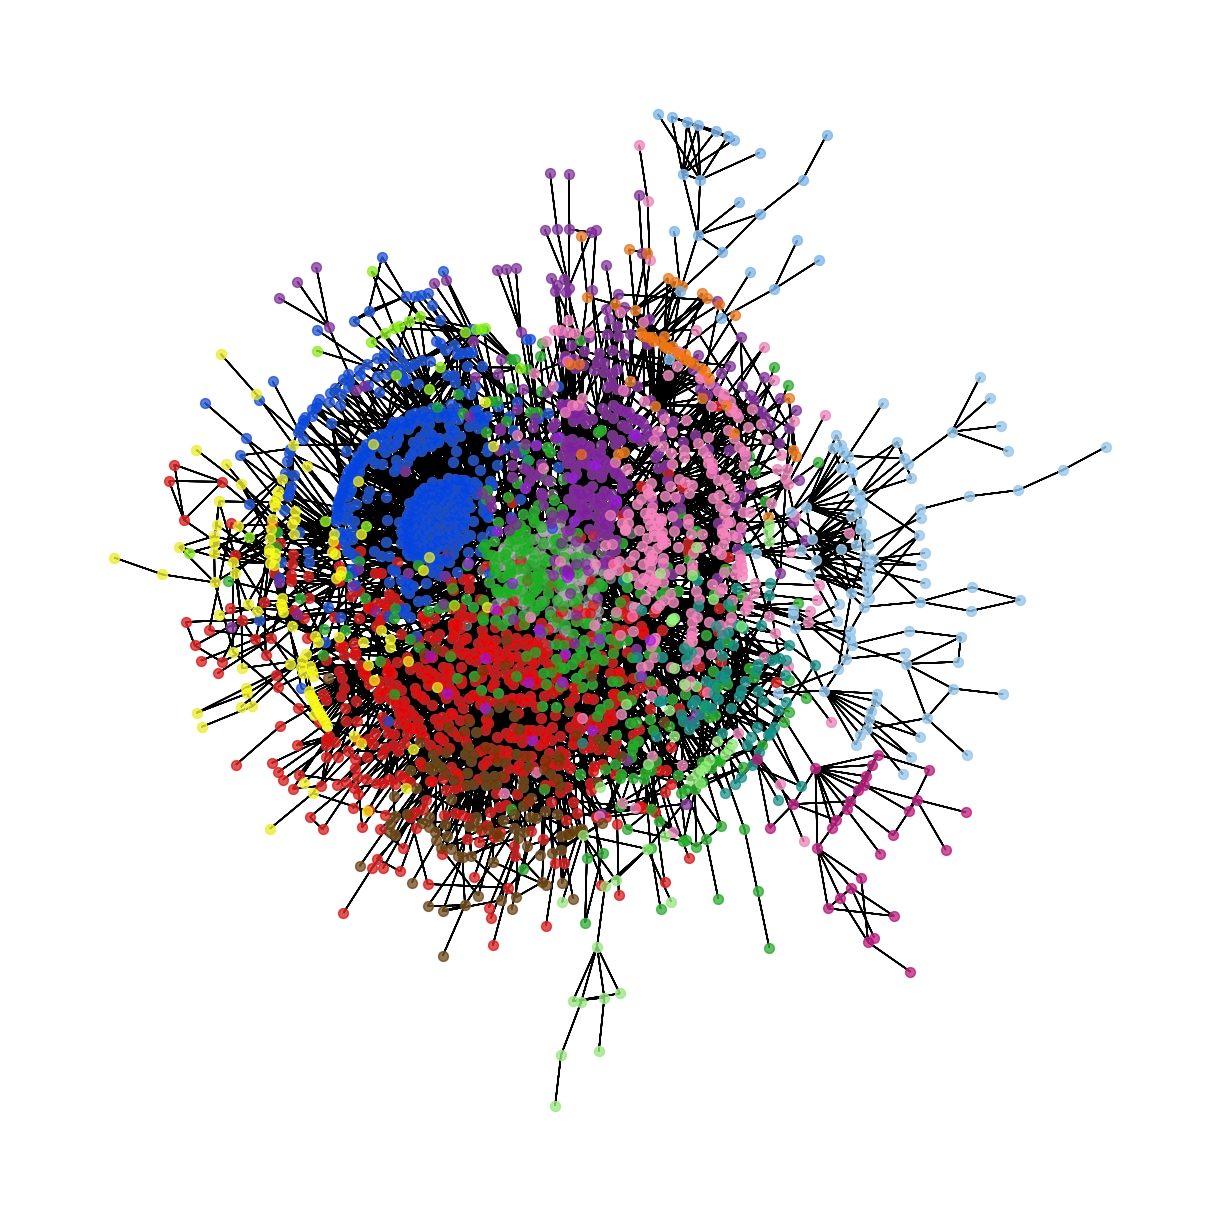

In [16]:
#将社区绘图
plt.figure(figsize=(12,12))
nx.draw(nx_g, pos, node_size = 50, alpha = 0.5, node_color=[[.7, .7, .7]], label = False)
for i in range(15):
    nx.draw(nx_g, pos, nodelist = list(commu_gn[i]), node_size = 50, alpha = 0.6, node_color=color_xkcd[i], label = False)
plt.show()

### 模块化社区划分：Louvain算法

In [77]:
from communities.algorithms import louvain_method
import numpy as np
adj_matrix = np.array(nx.adjacency_matrix(nx_g).todense()) #邻接矩阵的np格式
communities, _ = louvain_method(adj_matrix) #调用算法
communities.sort(key = lambda x:len(x), reverse = True) #按社区中节点数量排序，共114个社区

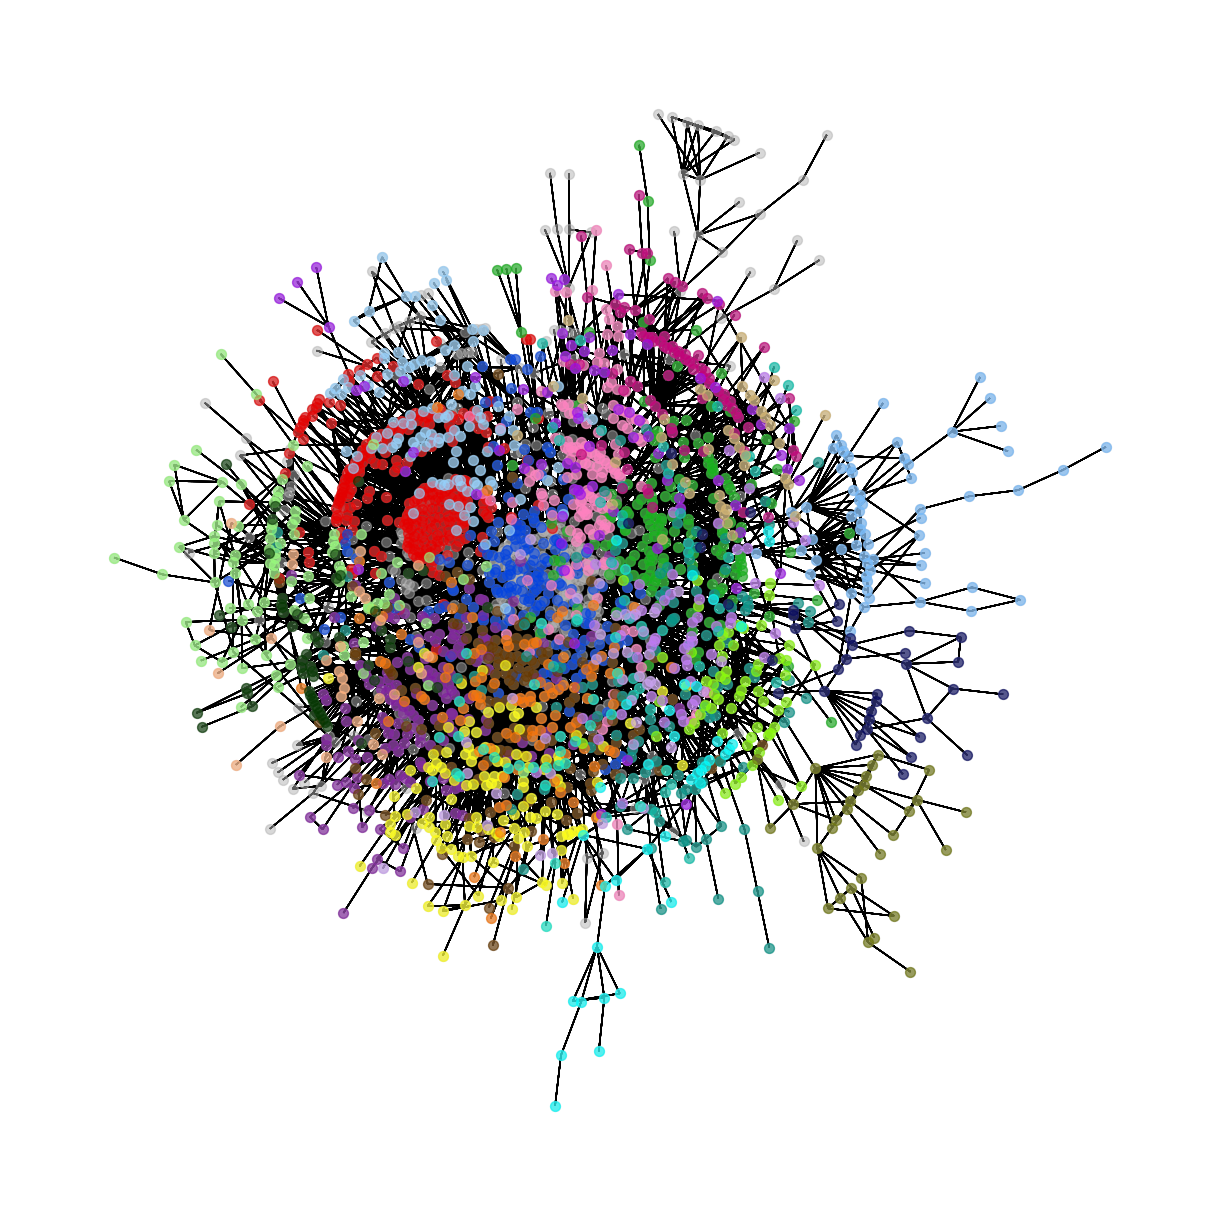

In [181]:
#绘制前25个
plt.figure(figsize=(12,12))
nx.draw(nx_g, pos, node_size = 50, alpha = 0.5, node_color=[[.7, .7, .7]], label = False)
for i in range(25):
    nx.draw(nx_g, pos, nodelist = list(communities[i]), node_size = 50, alpha = 0.6, node_color=color_xkcd[i], label = False)
plt.show()

## 基于节点的社区划分

### k-means算法

In [18]:
#计算两个节点的jaccard相似度
def jaccard_sim(n1, n2):
    a, b = set(nx.all_neighbors(nx_g, n1)), set(nx.all_neighbors(nx_g, n2))
    unions = len(a.union(b))
    intersections = len(a.intersection(b))
    return intersections / unions

In [19]:
#计算两个节点的cosine相似度
import numpy as np
def cosine_sim(n1, n2):
    a, b = set(nx.all_neighbors(nx_g, n1)), set(nx.all_neighbors(nx_g, n2))
    return len(a.intersection(b))/np.sqrt(len(a)*len(b))

In [20]:
#将所有节点的jaccard相似度存储在矩阵中便于调用
import numpy as np
jaccard_matrix = np.zeros((2708, 2708))
for i in range(2708):
    for j in range(2708):
        jaccard_matrix[i][j] = jaccard_sim(i, j)
jaccard_matrix

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.33333333],
       [0.        , 0.        , 0.        , ..., 0.        , 0.33333333,
        1.        ]])

In [21]:
#将所有节点的cosine相似度存储在矩阵中便于调用
import numpy as np
cosine_matrix = np.zeros((2708, 2708))
for i in range(2708):
    for j in range(2708):
        cosine_matrix[i][j] = cosine_sim(i, j)
cosine_matrix

array([[1. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 1. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 1. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 1. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 1. , 0.5],
       [0. , 0. , 0. , ..., 0. , 0.5, 1. ]])

In [22]:
#存储节点之间最短路径
import communities
distance = dict(nx.all_pairs_shortest_path_length(nx_g))

In [23]:
#根据已有质心，将剩余节点进行分配
import random
def allot_cluster(medoids, similarity):
    #初始簇，只包含质心
    res = {}
    for i in range(len(medoids)):
        res[i] = {medoids[i]}
    #将所有非质心节点进行分配
    matrix = jaccard_matrix if similarity == 'jaccard' else cosine_matrix
    for node in range(2708):
        if node not in set(medoids):
            #计算当前节点与所有质心的相似度
            sim_list = [matrix[node][medoid] for medoid in medoids]
            if max(sim_list) == 0: #分配到距离最近的质心
                dis_list = []
                for medoid in medoids:
                    if medoid in distance[node]:
                        dis_list.append(distance[node][medoid])
                    else:
                        dis_list.append(float('inf'))
                max_cluster = dis_list.index(min(dis_list))
            else:
                max_cluster = sim_list.index(max(sim_list)) #取相似度最大的簇
            res[max_cluster].add(node) #分配给该簇
    return res

In [24]:
#重新设定质心
def re_medoid(res, similarity):
    k = len(res)
    new_medoids = []
    matrix = jaccard_matrix if similarity == 'jaccard' else cosine_matrix
    for i in range(k):
        cluster = res[i] #当前簇所包含的节点集合
        sim_dict = {} #记录每个节点的总相似度
        for node in cluster:
            sim_dict[node] = sum([matrix[node][medoid] for medoid in cluster]) #计算每个节点到其余节点的总相似度
        sim_dict = sorted(sim_dict.items(), key = lambda x:x[1], reverse = True) #按相似度排序
        new_medoid = sim_dict[0][0] #取总相似度最大的节点作为新的质心
        new_medoids.append(new_medoid)
    return new_medoids

In [25]:
#绘制聚类结果
def kmeans_show(res):
    k = len(res)
    plt.figure(figsize=(16,16))
    nx.draw(nx_g, pos, node_size = 50, alpha = 0.5, node_color=[[.7, .7, .7]], label = False)
    for i in range(k):
        nx.draw(nx_g, pos, nodelist = list(res[i]), node_size = 50, alpha = 0.6, node_color=color_xkcd[i], label = False)
    plt.show()

In [26]:
#聚类函数
from tqdm import tqdm
def kmeans(k, m, similarity):
    medoids = np.random.randint(0, 2708, size = k).tolist() #随机选取初始质心
    res = allot_cluster(medoids, similarity) #根据已有质心分配后的结果
    #重复迭代m次
    for cnt in tqdm(range(m)):
        medoids = re_medoid(res, similarity) #根据当前聚类结果，重新分配每个簇的质心
        res = allot_cluster(medoids, similarity) #根据已有质心分配后的结果
    return res    

In [27]:
res = kmeans(15, 5000, 'jaccard')

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [20:04<00:00,  4.15it/s]


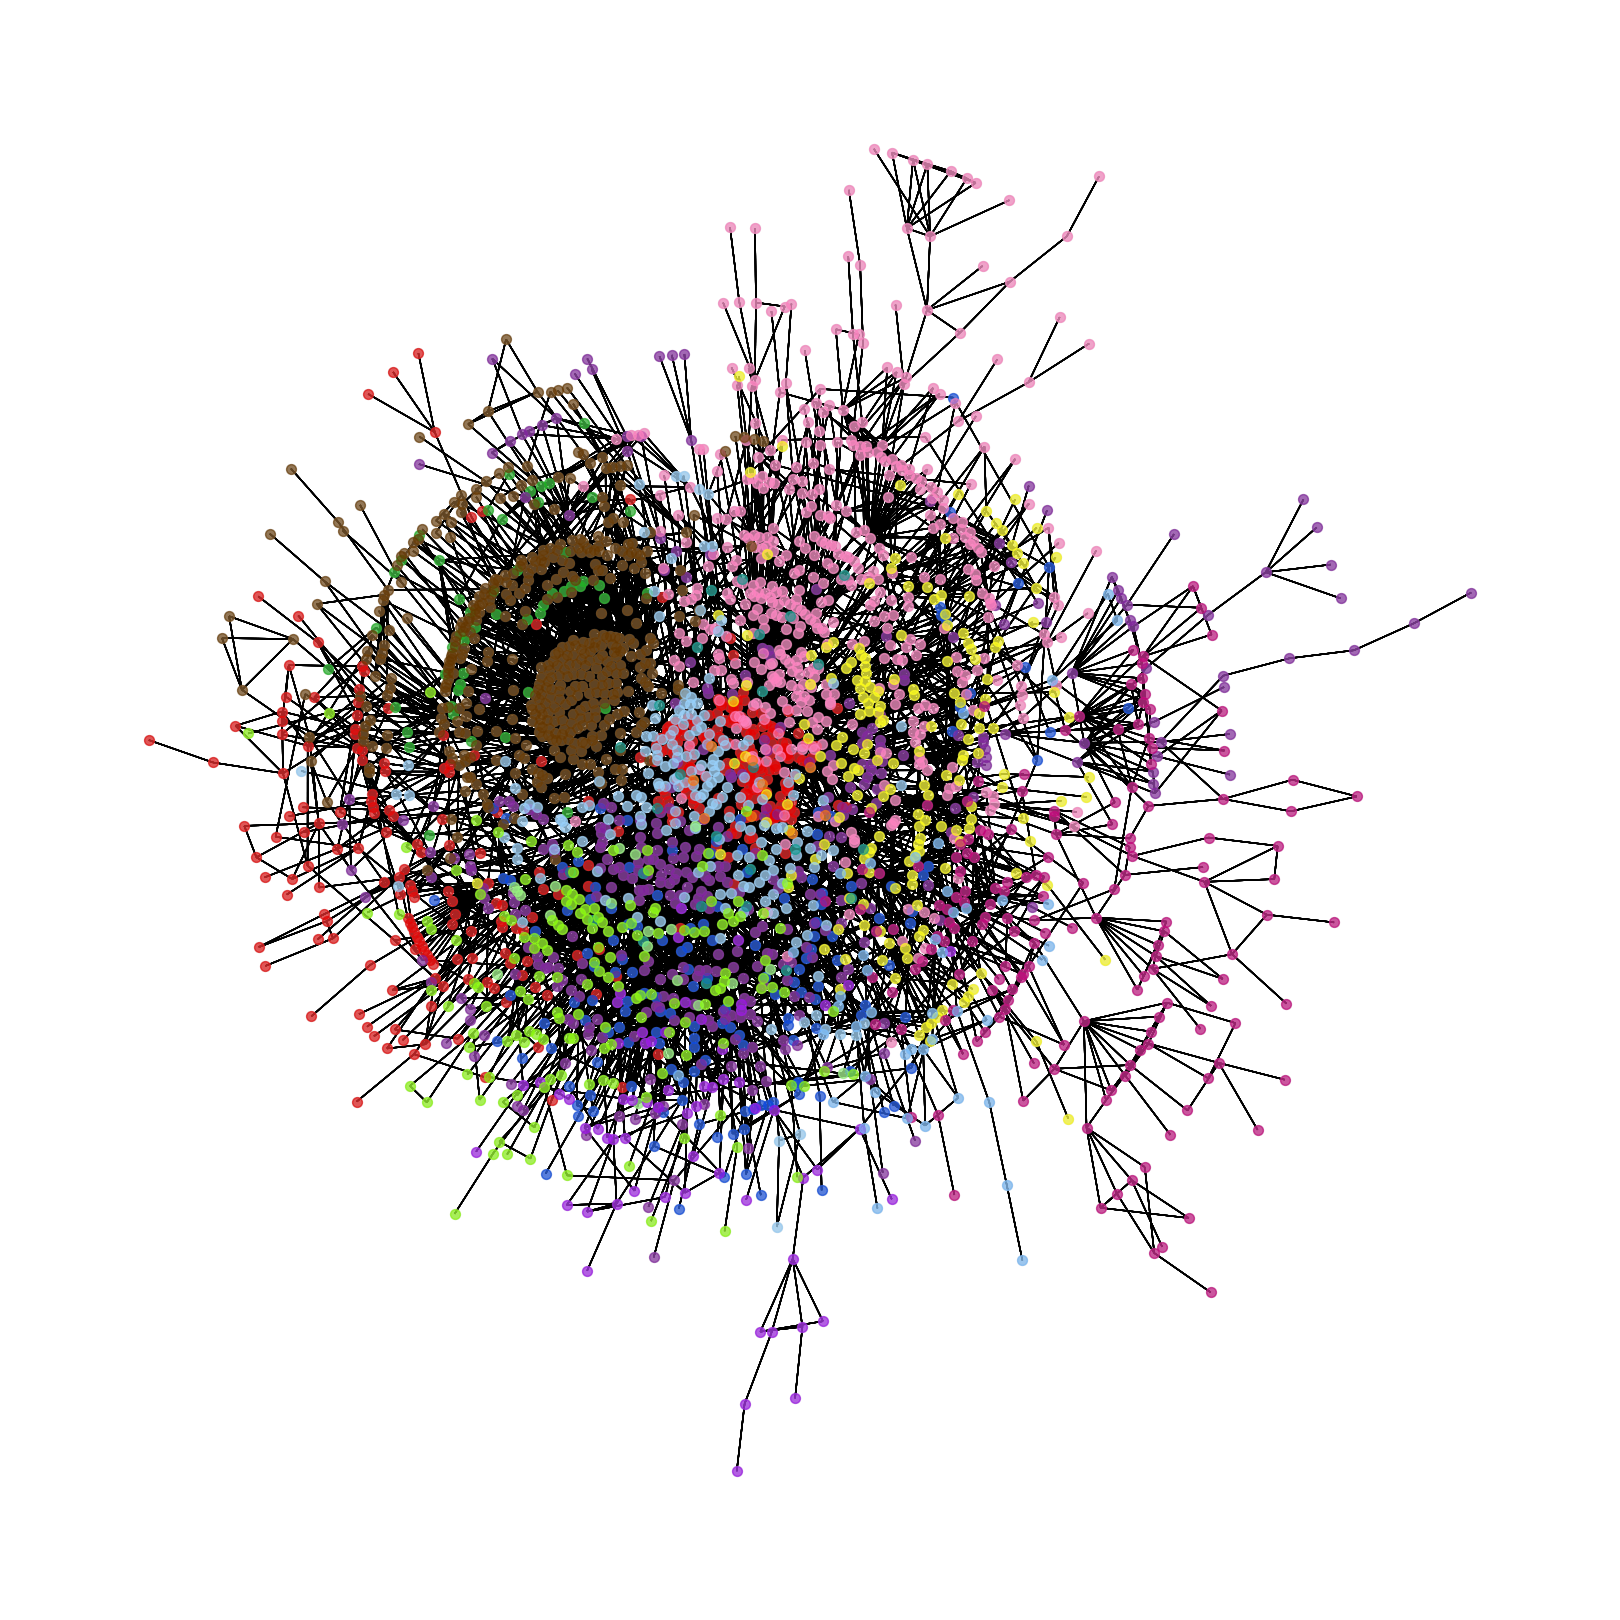

In [28]:
kmeans_show(res)